In [1]:
#Импортируем библиотеки для работы
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [35]:
#проверям тип данных
orders.dtypes

#!!!WARNING!!!value - обжекты и разделены запятой, мы не сможем их посчитать без преобразования

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [2]:
orders = pd.read_csv('hw_bootstrap.csv',sep=";") #считываем данные
orders.head() #смотрим хэд

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [36]:
#проверяем на пропуски
orders.isna().sum()
#красота:

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [38]:
#Приведём данные в нужный формат, избавимся от запятой и создадим переменную со знаениями контрольной группы
Control = orders.query("experimentVariant == 'Control'").value.str.replace(",", ".").astype(float)

In [39]:
#Аналогично для тестовой группы
Treatment = orders.query("experimentVariant == 'Treatment'").value.str.replace(",", ".").astype(float)

In [40]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

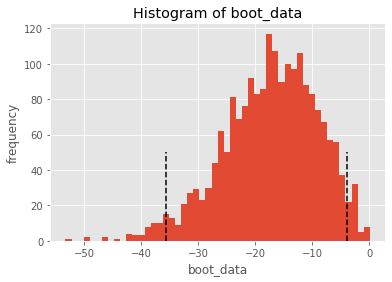

In [42]:
# Применяем бутстрап (с np.mean)
booted_data = get_bootstrap(Control, Treatment, boot_it = 2000)

# на графике видно, что доверительный интервал НЕ пересёк НОЛЬ, значит мы можем отклонить нулевую гипотезу

In [44]:
#убедимся в этом:
booted_data["p_value"]
#можно утверждать, что разница между средними в контрольной и тестовой группах наблюдается

0.03540995882303718

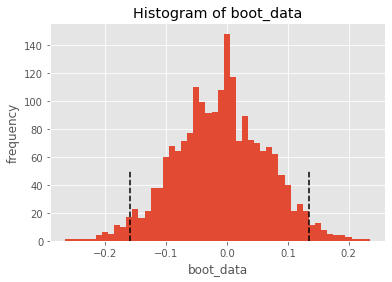

In [45]:
# Применяем бутстрап (с np.median)
booted_data_2 = get_bootstrap(Control, Treatment, boot_it = 2000, statistic = np.median)
# на графике видно, что доверительный интервал теперь пересекает НОЛЬ, значит мы НЕ можем отклонить нулевую гипотезу

In [47]:
#убедимся в этом:
booted_data_2["p_value"]
#можно утверждать, что разница между медианами в контрольной и тестовой группах НЕ наблюдается

0.8873680260748457

In [ ]:
#поищем выбросы

In [65]:
Control.sort_values().tail(6)
#чисто

415    12.511711
219    12.598569
363    12.663784
294    12.728285
195    12.817541
171    13.130346
Name: value, dtype: float64

In [67]:
Treatment.sort_values().tail(6)
#вот они, мои хорошие, картинку-то нам и подпортили

671      13.130346
995    1000.000000
996    1200.000000
997    1500.000000
998    2000.000000
999    3000.000000
Name: value, dtype: float64

In [71]:
Treatment_drop = Treatment.drop([995,996,997,998,999],axis=0)
#избавлямся от выбросов

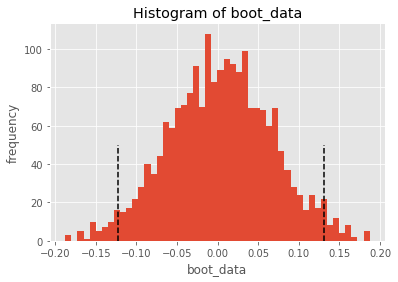

In [73]:
# Применяем бутстрап (с np.mean), но без выбросов
booted_data_3 = get_bootstrap(Control, Treatment_drop, boot_it = 2000)

# на графике видно, что доверительный интервал пересёк НОЛЬ, значит мы НЕ можем отклонить нулевую гипотезу

In [75]:
#убедимся в этом:
booted_data_3["p_value"]
#можно утверждать, что разница между средними в контрольной и тестовой (без выбросов) группах НЕ наблюдается

0.953016547009703

In [77]:
#Ну и наконец пробуем применить на нашу историю критерий Манна-Витни:
mannwhitneyu(Control, Treatment)
#вуаля, нулевую гипотезу о том, что распределения друг от друга мы отклонить не можем

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

In [79]:
#Скомим ему данные без выбросов и получем ещё более убедительный p-уровень:
mannwhitneyu(Control, Treatment_drop)

MannwhitneyuResult(statistic=124189.5, pvalue=0.9228386264147465)

Выводы:
1. Не столь чувствительный к выбросам критерий Манна-Витни даёт нам достаточно точный результат: данные в обоих выборках распределены +/- равнозначно.
2. Бутстрап по медиане также говорит о том, что медианы в выборках значимо не отличаются.
3. Бутстрап по среднему дал осечку. Оно и логично, среднее очень сильно зависит от выбросов, которых у нас 5 штук, т.о. мы получили значимые различия в средних.
4. Избавив данные от выбросов мы видим, что бутстрап теперь также не даёт нам значимых различий и м/у средними выборок